# Model testing

### Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


### Variables

In [2]:
target_col = "movie_score"
drop_cols = ["movie_score", "averageRating", "numVotes", "Unnamed: 0", "_orig_order"]

### Retrieve data

In [3]:
useBackslash = True
testDatasetPath = r'.\data\test_dataset.csv' if useBackslash else r'./data/test_dataset.csv'
final_model = joblib.load("xgb_reg_movie_number_votes.joblib")
df_test = pd.read_csv(testDatasetPath, sep=";")


### Prepare test data

In [4]:
# Load model and data, transform the log scalled data back
y_true = np.expm1(df_test[target_col].values)
X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])


### Create prediction on test

In [5]:
# Predict and turn the prediction back to normal scale 
y_pred = np.expm1(final_model.predict(X_test))

c:\Users\ander\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\core.py:774: UserWarning: [16:04:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


### Calculate MAE, RMSE and R^2

In [6]:
# Metrics (only if ground truth available)
if y_true is not None:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(np.log1p(y_true), np.log1p(y_pred))
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
else:
    print("Ground-truth 'movie_score' not found in test set; only predictions are available.")


MAE:  2091.7480
RMSE: 17865.9246
R2:   0.5401


## Bin testing

Classification report (per bin):
              precision    recall  f1-score   support

        0-10       0.00      0.00      0.00      5545
       10-50       0.55      0.55      0.55     21845
      50-100       0.18      0.28      0.22      8247
     100-500       0.39      0.48      0.43     14836
    500-1000       0.19      0.18      0.18      4343
   1000-5000       0.39      0.30      0.34      6395
  5000-10000       0.19      0.15      0.17      1255
 10000-20000       0.18      0.12      0.15       852
 20000-40000       0.20      0.15      0.17       544
      40000+       0.68      0.49      0.57       838

    accuracy                           0.38     64700
   macro avg       0.29      0.27      0.28     64700
weighted avg       0.36      0.38      0.37     64700


Accuracy: 0.383
Balanced accuracy: 0.268
Saved confusion matrix to .\data\confusion_matrix_bins.csv


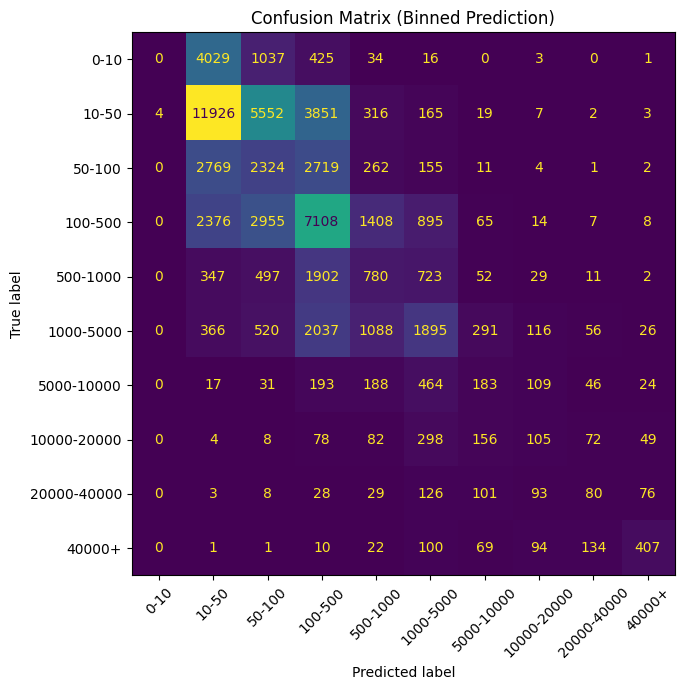

Saved per-class metrics to .\data\classification_metrics_per_bin.csv

Ordinal (off-by-one) metrics:
Exact-bin accuracy: 0.383
Off-by-one accuracy (±1 bin): 0.763
Mean absolute bin error: 0.93
Saved per-bin off-by-one recall to .\data\off_by_one_recall_per_bin.csv


,true_bin,class,off_by_one_recall
0,0,0-10,0.726601
1,1,10-50,0.800275
2,2,50-100,0.947254
3,3,100-500,0.773187
4,4,500-1000,0.784020
5,5,1000-5000,0.511962
6,6,5000-10000,0.602390
7,7,10000-20000,0.390845
8,8,20000-40000,0.457721
9,9,40000+,0.645585


In [7]:

# --- Treat regression output as a *classification* (ordinal) problem via binning ---

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Define bins (must match the binning used elsewhere / in training)
bin_edges = [0, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 40000, np.inf]
bin_labels = [
    "0-10", "10-50", "50-100", "100-500", "500-1000",
    "1000-5000", "5000-10000", "10000-20000", "20000-40000", "40000+"
]

# Defensive: if any predictions/targets are negative, clip to 0 so they can be binned
y_true_clip = np.maximum(np.asarray(y_true), 0)
y_pred_clip = np.maximum(np.asarray(y_pred), 0)

eval_df = pd.DataFrame({"y_true": y_true_clip, "y_pred": y_pred_clip})

# Create class labels for TRUE and PREDICTED by binning the continuous values
eval_df["true_class"] = pd.cut(
    eval_df["y_true"], bins=bin_edges, labels=bin_labels,
    right=False, include_lowest=True
)
eval_df["pred_class"] = pd.cut(
    eval_df["y_pred"], bins=bin_edges, labels=bin_labels,
    right=False, include_lowest=True
)

# Convert to ordered categoricals so we also have numeric bin indices (0..K-1)
true_cat = pd.Categorical(eval_df["true_class"], categories=bin_labels, ordered=True)
pred_cat = pd.Categorical(eval_df["pred_class"], categories=bin_labels, ordered=True)

y_true_cls = true_cat.astype(str)   # for sklearn classification_report (string labels)
y_pred_cls = pred_cat.astype(str)

# If any values fell outside bins (shouldn't with 0..inf), drop them safely
mask_valid = (true_cat.codes != -1) & (pred_cat.codes != -1)
y_true_cls_valid = y_true_cls[mask_valid]
y_pred_cls_valid = y_pred_cls[mask_valid]

true_codes = true_cat.codes[mask_valid]  # integer bin indices
pred_codes = pred_cat.codes[mask_valid]

# --- Standard classification metrics ---
acc = accuracy_score(y_true_cls_valid, y_pred_cls_valid)
bacc = balanced_accuracy_score(y_true_cls_valid, y_pred_cls_valid)

print("Classification report (per bin):")
print(classification_report(y_true_cls_valid, y_pred_cls_valid, labels=bin_labels, zero_division=0))
print(f"\nAccuracy: {acc:.3f}")
print(f"Balanced accuracy: {bacc:.3f}")

# Confusion matrix (labels in fixed order)
cm = confusion_matrix(y_true_cls_valid, y_pred_cls_valid, labels=bin_labels)
cm_df = pd.DataFrame(cm, index=bin_labels, columns=bin_labels)
cm_df.to_csv(r'.\data\confusion_matrix_bins.csv', sep=';')
print("Saved confusion matrix to .\\data\\confusion_matrix_bins.csv")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bin_labels)
fig, ax = plt.subplots(figsize=(9, 7))
disp.plot(ax=ax, xticks_rotation=45, values_format="d", colorbar=False)
plt.title("Confusion Matrix (Binned Prediction)")
plt.tight_layout()
plt.show()

# Save a tidy per-class metrics table
prec, rec, f1, support = precision_recall_fscore_support(
    y_true_cls_valid, y_pred_cls_valid, labels=bin_labels, zero_division=0
)
per_class = pd.DataFrame({
    "class": bin_labels,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})
per_class.to_csv(r'.\data\classification_metrics_per_bin.csv', sep=';', index=False)
print("Saved per-class metrics to .\\data\\classification_metrics_per_bin.csv")

# --- Off-by-one (ordinal) evaluation ---
exact_accuracy = float(np.mean(true_codes == pred_codes))
off_by_one_accuracy = float(np.mean(np.abs(true_codes - pred_codes) <= 1))
mean_abs_bin_error = float(np.mean(np.abs(true_codes - pred_codes)))

print("\nOrdinal (off-by-one) metrics:")
print(f"Exact-bin accuracy: {exact_accuracy:.3f}")
print(f"Off-by-one accuracy (±1 bin): {off_by_one_accuracy:.3f}")
print(f"Mean absolute bin error: {mean_abs_bin_error:.2f}")

# Per-bin off-by-one recall
df_bins = pd.DataFrame({"true_bin": true_codes, "pred_bin": pred_codes})
df_bins["off_by_one"] = (np.abs(df_bins["true_bin"] - df_bins["pred_bin"]) <= 1)
off_by_one_per_bin = (
    df_bins.groupby("true_bin")["off_by_one"]
           .mean()
           .reset_index(name="off_by_one_recall")
)
off_by_one_per_bin["class"] = off_by_one_per_bin["true_bin"].map(lambda i: bin_labels[i])
off_by_one_per_bin = off_by_one_per_bin[["true_bin", "class", "off_by_one_recall"]]
off_by_one_per_bin.to_csv(r'.\data\off_by_one_recall_per_bin.csv', sep=';', index=False)
print("Saved per-bin off-by-one recall to .\\data\\off_by_one_recall_per_bin.csv")

off_by_one_per_bin


In [8]:
# --- Optional: per-bin *regression* diagnostics (grouped by TRUE bin) ---

def metrics_for_slice(y_t, y_p):
    y_t = np.asarray(y_t)
    y_p = np.asarray(y_p)
    return {
        "count": int(len(y_t)),
        "mae": float(mean_absolute_error(y_t, y_p)),
        "rmse": float(np.sqrt(mean_squared_error(y_t, y_p))),
        "median_abs_err": float(np.median(np.abs(y_p - y_t))),
        "mean_true": float(np.mean(y_t)),
        "mean_pred": float(np.mean(y_p)),
    }

bin_results = (
    eval_df.dropna(subset=["true_class"])
           .groupby("true_class", observed=True)
           .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))
           .reset_index()
           .rename(columns={"true_class": "bin"})
)

print("\nPer-bin regression diagnostics (binned by TRUE movie_score):")
print(bin_results.to_string(index=False))

bin_results.to_csv(r'.\\data\\performance_regression_binned_by_true.csv', sep=';', index=False)
print("Saved per-bin regression diagnostics to .\\data\\performance_regression_binned_by_true.csv")



Per-bin regression diagnostics (binned by TRUE movie_score):
        bin   count          mae          rmse  median_abs_err     mean_true    mean_pred
       0-10  5545.0    68.666291    921.704851       26.428612      7.424166    76.090462
      10-50 21845.0    93.420293   1006.121544       24.343590     23.738567   115.043602
     50-100  8247.0   153.251021   1487.884863       37.768272     70.671759   196.087128
    100-500 14836.0   336.465300   2332.778064      127.308502    233.517660   405.459381
   500-1000  4343.0   812.122592   2488.086078      474.386475    706.105227   857.571350
  1000-5000  6395.0  2298.895617   7213.801346     1339.173828   2189.017201  2015.629028
 5000-10000  1255.0  6670.465058  12559.103230     5151.897339   7028.812749  5723.522461
10000-20000   852.0 12677.017306  21741.901139    10417.690826  14081.359155 10718.780273
20000-40000   544.0 21662.734187  27418.400829    20624.525391  28386.556985 18102.546875
     40000+   838.0 92450.652358 15119

C:\Users\ander\AppData\Local\Temp\ipykernel_25272\3728221020.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))


In [9]:
bin_results.to_csv(r'.\data\performance_binned_by_true.csv', sep=';')

In [10]:
eval_df["pred_bin"] = pd.cut(
    eval_df["y_pred"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
    include_lowest=True
)

pred_bin_results = (
    eval_df.dropna(subset=["pred_bin"])
           .groupby("pred_bin", observed=True)
           .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))
           .reset_index()
)

print("\nPer-bin performance (binned by PREDICTED movie_score):")
print(pred_bin_results.to_string(index=False))



Per-bin performance (binned by PREDICTED movie_score):
   pred_bin   count          mae          rmse  median_abs_err     mean_true     mean_pred
       0-10     4.0    10.498499     14.971584        5.481363     19.500000      9.001501
      10-50 21838.0    88.915689    665.334666       18.989229    100.173734     31.982767
     50-100 12933.0   203.182215   1061.397955       48.402084    223.095647     70.314850
    100-500 18351.0   552.528291   3126.964314      143.705826    622.223966    225.190018
   500-1000  4209.0  1727.268227   7107.407858      511.018494   1937.885246    707.610596
  1000-5000  4837.0  4646.194915  17489.471190     1342.265747   5262.759975   2163.840820
 5000-10000   947.0 11045.593011  24045.117440     5088.344727  13192.574446   6997.798340
10000-20000   574.0 18469.142365  34674.844365    10017.363770  22665.538328  14100.575195
20000-40000   409.0 37574.032726  66019.892979    19964.142578  46122.176039  28635.658203
     40000+   598.0 91060.448304 1

C:\Users\ander\AppData\Local\Temp\ipykernel_25272\1288564663.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))


In [11]:
pred_bin_results.to_csv(r'.\data\performance_binned_by_predicted.csv', sep=';')

### Create a preview dataframe

In [12]:
# Preview predictions
preview = pd.DataFrame({"predicted_movie_score": y_pred, "residual": abs(y_pred - y_true)})
if y_true is not None:
    preview.insert(0, "actual_movie_score", y_true)


### Create a dataframe of feature importance

In [13]:
importances = final_model.feature_importances_

# Feature names (if trained with a DataFrame)
feature_names = final_model.feature_names_in_

# Create sorted DataFrame
features = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

In [14]:
features.to_csv(r'.\data\feature_importance.csv', sep=';')

### Graph over residuals

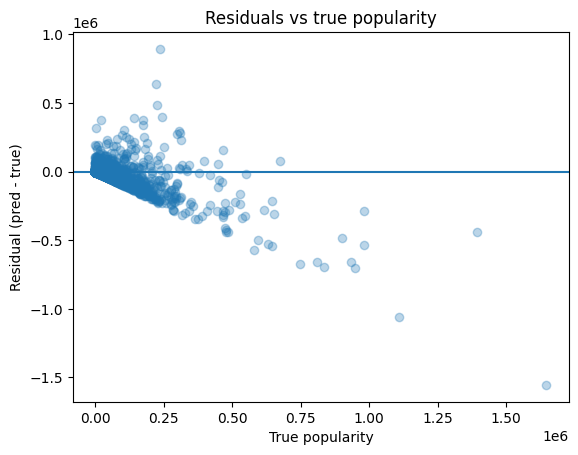

In [15]:
residuals = y_pred - y_true

plt.figure()
plt.scatter(y_true, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("True popularity")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs true popularity")
plt.show()


### Bias plot

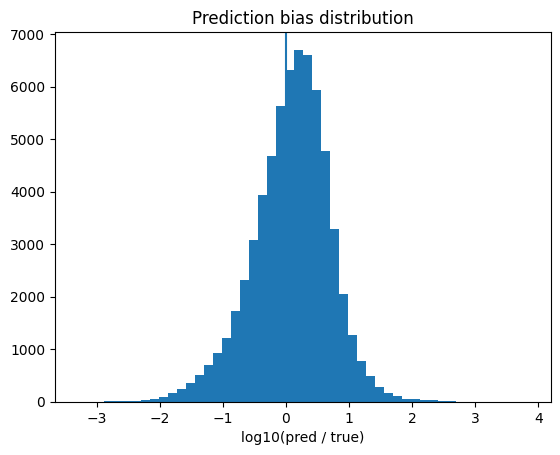

In [16]:
ratio = y_pred / (y_true + 1e-9)
plt.figure()
plt.hist(np.log10(ratio), bins=50)
plt.axvline(0)  # log10(1)
plt.xlabel("log10(pred / true)")
plt.title("Prediction bias distribution")
plt.show()

